# Poisson Noise Treatment

In [1]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import skimage
# from skimage.util import random_noise

The method "cv.imread()" returned:
An image of <class 'numpy.ndarray'>.
The shape of the "img" is (2494, 2048, 3)
Where each element has type: <class 'numpy.uint8'>
The x dimension is 2048, the y dim is 2494 andthe number of channels is 3


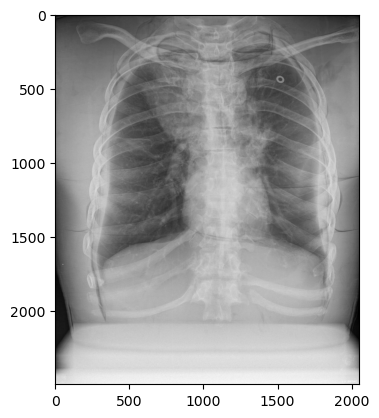

In [2]:
img_location: str = '../images/img_2048x2494x15.jpg'
img = cv.imread(img_location)
plt.imshow(img)
print(f"The method \"cv.imread()\" returned:\nAn image of {type(img)}.\n\
The shape of the \"img\" is {img.shape}\n\
Where each element has type: {type(img[0, 0, 0])}")
nrow, ncol, nch = img.shape
print(f"The x dimension is {ncol}, the y dim is {nrow} and\
the number of channels is {nch}")
plt.show()

- **NOTE**: The image has some extra pixels in the y-axis. Before proceeding we crop it.

The cropped image has dimensions: (2048, 2048, 3)


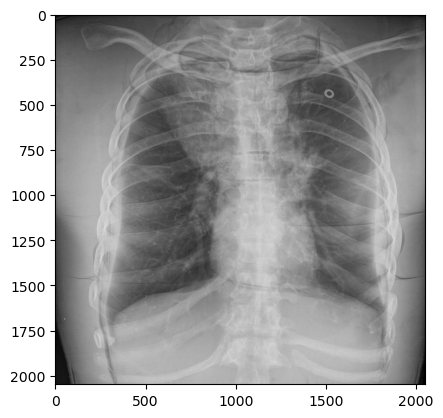

In [3]:
cropped_img = img[0:2048, :, :]
cv.imwrite('../images/cropped_img.jpg', cropped_img)
plt.imshow(cropped_img)
print(f"The cropped image has dimensions: {cropped_img.shape}")
plt.show()

## Adding Poisson Noise

### Poisson Distribution Review
- The Poisson distribution has the following form:
$$f(k;\lambda) = \frac{\lambda^ke^{-\lambda}}{k!},$$
- where, $k$ is the light intensity (number of photons per unit of time measured) and $\lambda$ is the expected value which is also its variance.
- Direct numerical applications of the Poisson distribution will suffer from overflow due to its exponential nature. A mapping from the $k$ values of $\left(0, \infty\right)$ to the interval $\left(0, 1\right)$ it is required. 

In [15]:
def apply_poisson_noise(image):
    # we convert image from unit8 to float (to use Poisson random generator)
    darray_of_floats = np.dtype('float64').type
    image = image / 255  # normalization so every value belongs to <0, 1>
    image = np.asarray(image, darray_of_floats)

    # Determine the number unique values and its closest upper limit power of 2
    n_unique_values = len(np.unique(image))
    n_unique_values = 2 ** np.ceil(np.log2(n_unique_values))

    # we seed our random variable generator
    # Applying Poisson noise to scaled pixel by the number of unique values
    # Then we normalize for the scale factor
    rng = np.random.default_rng()
    out = rng.poisson(image * n_unique_values) / float(n_unique_values)
    # The application of noise can exceed the max range of the mean passed:
    if out.max() > 1.0:
        out = np.clip(out, 0, 1.0)
    return out
# help(np.random.default_rng().poisson)

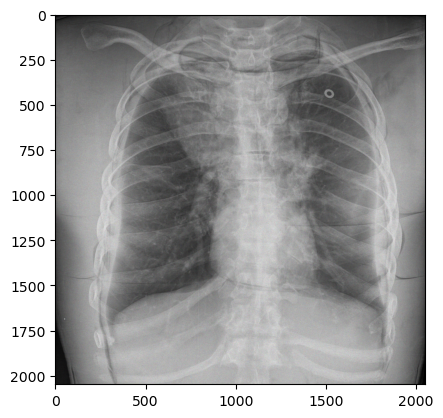

In [16]:
# img_with_applied_poisson_noise = apply_poisson_noise(cropped_img)
noisy_img = apply_poisson_noise(cropped_img)
plt.imshow(noisy_img)
# we scale back before saving to float from <0, 1> to unit <0, 255>
conv = noisy_img * 255
# need to convert before saving
skimage.io.imsave('../images/img_with_poisson_noise.jpg', conv.astype(np.uint8))
plt.show()

# References:
1.  Some useful opencv filters: [the ai codes](https://theai.codes/computer-vision/a-list-of-the-most-useful-opencv-filters/)
2.  Some methods to generate noisy from the `scikit-image` module: [noise scikit-image-utils](https://github.com/scikit-image/scikit-image/blob/417104097a0d4b5c3500bd05cf32fbdacee895ee/skimage/util/noise.py#L135)
3. Difference between adding noise and applying noise: [Poisson noise is not added but applied](https://tomroelandts.com/articles/gaussian-noise-is-added-poisson-noise-is-applied)